## **Extraccion de Datos**

In [1]:
## Librerias
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
from tqdm import tqdm  # pip install tqdm
import datetime as dt
import re, time
import json

### **Driver Setup**

In [2]:
# enlace = "https://neoauto.com/auto/seminuevo/bmw-x2-2019-1849978"
enlace = "https://neoauto.com/auto/seminuevo/bmw-x3-20i-2021-1851204"

In [3]:
options = webdriver.ChromeOptions()
# options.add_argument("--headless")   # modo oculto
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")
# options.add_experimental_option("excludeSwitches", ["enable-automation"])
# options.add_experimental_option('useAutomationExtension', False)
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options = options)
# driver.minimize_window()
driver.get(enlace)

### **Descripcion del elemento**

In [5]:
# Buscar la descripción por la clase
descripcion_element = driver.find_element(By.CSS_SELECTOR, "div.flex.w-full.flex-col.gap-3xlarge.whitespace-pre-wrap.break-words")
descripcion_texto = descripcion_element.text

print("Descripción extraída:\n", descripcion_texto)

Descripción extraída:
 ☑️Seminueva
☑️Único dueño
☑️Motor: I4 2.0 Twin Turbo
☑️Caja secuencial con Paddle Shift
☑️Apple car Play y Android auto
☑️Cámara y sensores con asistencia
☑️Asientos de cuero eléctricos con memorias 
☑️Aros 19” 
☑️Climatizador Bi-zona automát...
Seguir leyendo


### **Elementos de la tabla**

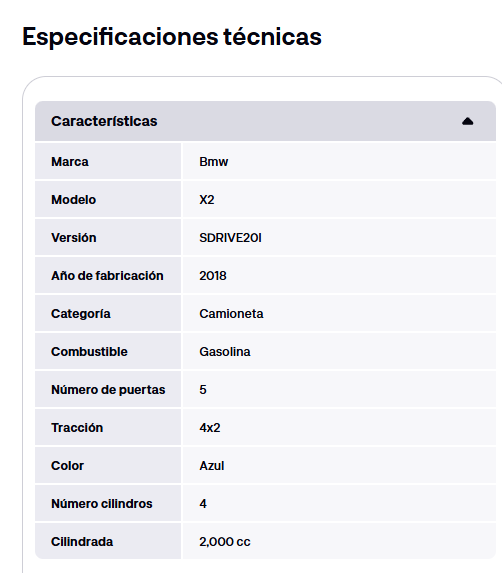

In [19]:
# Localizar directamente la tabla de especificaciones
grid = driver.find_element(By.CSS_SELECTOR, "div.grid.grid-cols-2")

# Obtener todas las celdas (div hijos)
cells = grid.find_elements(By.XPATH, "./div")

# Armar diccionario con pares
specs = {}
for i in range(0, len(cells), 2):
    key = cells[i].text.strip()
    val = cells[i+1].text.strip()
    specs[key] = val

specs

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.grid.grid-cols-2"}
  (Session info: chrome=141.0.7390.108); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x0x64fe83+66515]
	GetHandleVerifier [0x0x64fec4+66580]
	(No symbol) [0x0x43dc48]
	(No symbol) [0x0x488704]
	(No symbol) [0x0x488aab]
	(No symbol) [0x0x4cf482]
	(No symbol) [0x0x4ab214]
	(No symbol) [0x0x4ccba7]
	(No symbol) [0x0x4aafc6]
	(No symbol) [0x0x47c2ca]
	(No symbol) [0x0x47d154]
	GetHandleVerifier [0x0x8a73b3+2521347]
	GetHandleVerifier [0x0x8a2333+2500739]
	GetHandleVerifier [0x0x677cd4+229924]
	GetHandleVerifier [0x0x668238+165768]
	GetHandleVerifier [0x0x66eced+193085]
	GetHandleVerifier [0x0x658198+100072]
	GetHandleVerifier [0x0x658330+100480]
	GetHandleVerifier [0x0x6425ea+11066]
	BaseThreadInitThunk [0x0x74ff5d49+25]
	RtlInitializeExceptionChain [0x0x7710d6db+107]
	RtlGetAppContainerNamedObjectPath [0x0x7710d661+561]


In [20]:
print(json.dumps(specs, indent=2, ensure_ascii=False))

NameError: name 'specs' is not defined

In [70]:
CDN_HINT = "cdn.neoauto.com/elements/autos"

def _best_from_srcset(srcset: str) -> str | None:
    if not srcset:
        return None
    cand = []
    for part in srcset.split(","):
        bits = part.strip().split()
        if not bits:
            continue
        url = bits[0]
        w = 0
        if len(bits) > 1 and bits[1].endswith("w"):
            try:
                w = int(re.sub(r"\D", "", bits[1]))
            except:
                w = 0
        cand.append((w, url))
    return max(cand)[1] if cand else None

def get_image_urls(driver, timeout=15):
    wait = WebDriverWait(driver, timeout)
    wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
    urls = set()

    # --------- A) Intento 1: modal abierto (slick-list con "Foto Galeria") ----------
    modal_selectors = [
        "div[role='dialog'] .slick-list picture img",
        "div[aria-modal='true'] .slick-list picture img",
        "div[role='dialog'] .slick-list picture source",
        "div[aria-modal='true'] .slick-list picture source",
        "div[role='dialog'] .slick-list picture[style*='background-image']",
        "div[aria-modal='true'] .slick-list picture[style*='background-image']",
    ]
    for sel in modal_selectors:
        for el in driver.find_elements(By.CSS_SELECTOR, sel):
            tag = el.tag_name.lower()
            if tag == "img":
                hi = _best_from_srcset(el.get_attribute("srcset") or "")
                src = hi or (el.get_attribute("src") or "")
                if CDN_HINT in src:
                    urls.add(src)
                ds = el.get_attribute("data-src") or ""
                if CDN_HINT in ds:
                    urls.add(ds)
            elif tag == "source":
                ss = el.get_attribute("srcset") or ""
                best = _best_from_srcset(ss)
                if best and CDN_HINT in best:
                    urls.add(best)
            else:  # picture con background-image
                style = el.get_attribute("style") or ""
                m = re.search(r"url\(['\"]?(.*?)['\"]?\)", style)
                if m and CDN_HINT in m.group(1):
                    urls.add(m.group(1))

    if urls:
        return sorted(urls)

    # --------- B) Intento 2: ficha (grid de 2 columnas con miniaturas) -------------
    # mueve a la galería para forzar lazy-load
    try:
        gallery = wait.until(EC.presence_of_element_located(
            (By.XPATH, "(//div[contains(@class,'grid') and contains(@class,'grid-cols-2')])[1]")
        ))
        driver.execute_script("arguments[0].scrollIntoView({block:'center'});", gallery)
        time.sleep(0.8)
    except Exception:
        pass

    ficha_selectors = [
        ".grid.grid-cols-2 picture img",
        ".grid.grid-cols-2 picture source",
        ".grid.grid-cols-2 picture[style*='background-image']",
        # comodín: cualquier img del CDN en la página
        f"img[src*='{CDN_HINT}']"
    ]
    for sel in ficha_selectors:
        for el in driver.find_elements(By.CSS_SELECTOR, sel):
            tag = el.tag_name.lower()
            if tag == "img":
                hi = _best_from_srcset(el.get_attribute("srcset") or "")
                src = hi or (el.get_attribute("src") or "")
                if CDN_HINT in src:
                    urls.add(src)
                ds = el.get_attribute("data-src") or ""
                if CDN_HINT in ds:
                    urls.add(ds)
            elif tag == "source":
                ss = el.get_attribute("srcset") or ""
                best = _best_from_srcset(ss)
                if best and CDN_HINT in best:
                    urls.add(best)
            else:
                style = el.get_attribute("style") or ""
                m = re.search(r"url\(['\"]?(.*?)['\"]?\)", style)
                if m and CDN_HINT in m.group(1):
                    urls.add(m.group(1))

    return sorted(urls)

In [36]:

# url = "https://neoauto.com/auto/seminuevo/bmw-x2-2019-1849978"
url = "https://neoauto.com/auto/seminuevo/bmw-x3-20i-2021-1851204"

driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
driver.get(url)
time.sleep(5)  # o usa WebDriverWait si prefieres

imagenes = get_image_urls(driver)
print(json.dumps(imagenes, indent=2, ensure_ascii=False))

# driver.quit()


[
  "https://cdn.neoauto.com/elements/autos_usados/960x584/463366/463366_4771876.webp",
  "https://cdn.neoauto.com/elements/autos_usados/960x584/463366/463366_4798510.webp",
  "https://cdn.neoauto.com/elements/autos_usados/960x584/463366/463366_6601495.webp",
  "https://cdn.neoauto.com/elements/autos_usados/960x584/463366/463366_8345200.webp",
  "https://cdn.neoauto.com/elements/autos_usados/960x584/463366/463366_9445936.webp"
]


## **Descargar Info Anuncio**

In [42]:
path = rf"C:\Users\PC\Desktop\Proyectos\Proyectos_Py\7.Analisis_Autos\vehiculos\data\categoria\neo_autos_autos_camionetas-suv_seminuevos.json"

In [43]:
with open(path, "r", encoding="utf-8") as f:
    data = json.load(f)

In [46]:
data[0]["url_auto"]

'https://neoauto.com/auto/seminuevo/bmw-x2-2019-1849978'

In [56]:
enlace_anuncio = []

for enlace_i in data:
    enlace_anuncio.append(
        {
            "titulo": enlace_i["titulo"],
            "tipo_vehiculo": enlace_i["tipo_vehiculo"],
            "url_auto": enlace_i["url_auto"]
        }
    )
    
print("Cantidad de enlaces:", len(enlace_anuncio))

Cantidad de enlaces: 596


In [57]:
enlace_anuncio[:5]

[{'titulo': 'Bmw X2 2019',
  'tipo_vehiculo': 'autos',
  'url_auto': 'https://neoauto.com/auto/seminuevo/bmw-x2-2019-1849978'},
 {'titulo': 'Dongfeng T5 Evo 2022',
  'tipo_vehiculo': 'autos',
  'url_auto': 'https://neoauto.com/auto/seminuevo/dongfeng-t5-evo-2022-1851263'},
 {'titulo': 'Bmw X3 20i 2021',
  'tipo_vehiculo': 'autos',
  'url_auto': 'https://neoauto.com/auto/seminuevo/bmw-x3-20i-2021-1851204'},
 {'titulo': 'Volvo Xc-90 2024',
  'tipo_vehiculo': 'autos',
  'url_auto': 'https://neoauto.com/auto/seminuevo/volvo-xc-90-2024-1837983'},
 {'titulo': 'Mazda Cx-60 2024',
  'tipo_vehiculo': 'autos',
  'url_auto': 'https://neoauto.com/auto/seminuevo/mazda-cx-60-2024-1844126'}]

In [64]:
options = webdriver.ChromeOptions()
# options.add_argument("--headless")   # modo oculto
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")
# options.add_experimental_option("excludeSwitches", ["enable-automation"])
# options.add_experimental_option('useAutomationExtension', False)
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options = options)

resultados = []

for enlace_i in tqdm(enlace_anuncio[:3], desc="Procesando anuncios"):
    url = enlace_i["url_auto"]
    
    driver.get(url)

    time.sleep(2)  # o usa WebDriverWait si prefieres
    
    # Buscar la descripción por la clase
    descripcion_element = driver.find_element(By.CSS_SELECTOR, "div.flex.w-full.flex-col.gap-3xlarge.whitespace-pre-wrap.break-words")
    descripcion_texto = descripcion_element.text
    
    ## Especificaciones
    # Localizar directamente la tabla de especificaciones
    grid = driver.find_element(By.CSS_SELECTOR, "div.grid.grid-cols-2")

    # Obtener todas las celdas (div hijos)
    cells = grid.find_elements(By.XPATH, "./div")

    # Armar diccionario con pares
    specs = {}
    for i in range(0, len(cells), 2):
        key = cells[i].text.strip()
        val = cells[i+1].text.strip()
        specs[key] = val
    
    
    ## llenado en un diccionario
    resultado = {
        "titulo": enlace_i["titulo"],
        "tipo_vehiculo": enlace_i["tipo_vehiculo"],
        "url_auto": enlace_i["url_auto"],
        "descripcion": descripcion_texto,
        "especificaciones": specs
    }
    
    resultados.append(resultado)

    

Procesando anuncios:  33%|███▎      | 1/3 [00:07<00:14,  7.06s/it]


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.grid.grid-cols-2"}
  (Session info: chrome=140.0.7339.208); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x0x47c333+65459]
	GetHandleVerifier [0x0x47c374+65524]
	(No symbol) [0x0x29d973]
	(No symbol) [0x0x2e76e7]
	(No symbol) [0x0x2e7a8b]
	(No symbol) [0x0x32dea2]
	(No symbol) [0x0x309e44]
	(No symbol) [0x0x32b606]
	(No symbol) [0x0x309bf6]
	(No symbol) [0x0x2db38e]
	(No symbol) [0x0x2dc274]
	GetHandleVerifier [0x0x6feda3+2697763]
	GetHandleVerifier [0x0x6f9ec7+2677575]
	GetHandleVerifier [0x0x4a4194+228884]
	GetHandleVerifier [0x0x4949f8+165496]
	GetHandleVerifier [0x0x49b18d+192013]
	GetHandleVerifier [0x0x4847d8+99416]
	GetHandleVerifier [0x0x484972+99826]
	GetHandleVerifier [0x0x46ebea+10346]
	BaseThreadInitThunk [0x0x75c35d49+25]
	RtlInitializeExceptionChain [0x0x771bd6db+107]
	RtlGetAppContainerNamedObjectPath [0x0x771bd661+561]


In [63]:
print(json.dumps(resultados, indent=2, ensure_ascii=False))

[
  {
    "titulo": "Bmw X2 2019",
    "tipo_vehiculo": "autos",
    "url_auto": "https://neoauto.com/auto/seminuevo/bmw-x2-2019-1849978",
    "descripcion": "Gildemeister Seminuevos Premium: Exclusividad y Confianza en Cada Kilómetro\n\nBMW X2 versión SDRIVE20I con 26,786 km del 2019, un vehículo de alto nivel que combina lujo, potencia y tecnología. Inspeccionado minuciosamente para garantizarte la mejor...\nSeguir leyendo"
  },
  {
    "titulo": "Dongfeng T5 Evo 2022",
    "tipo_vehiculo": "autos",
    "url_auto": "https://neoauto.com/auto/seminuevo/dongfeng-t5-evo-2022-1851263",
    "descripcion": "-VENDE ONE SEMINUEVOS\n-ENTREGA INMEDIATA\n-ACEPTAMOS VEHÍCULOS COMO PARTE DE PAGO.\n-DOCUMENTOS EN REGLA.\n-ÚNICO EN STOCK.\n-DESCUENTOS EN NUESTRO TALLER.\n\n*Financiamiento con los Bancos:\n-BBVA\n-BCP\n-SANTANDER\n-MAF\n\n*Servicio de GPS"
  },
  {
    "titulo": "Bmw X3 20i 2021",
    "tipo_vehiculo": "autos",
    "url_auto": "https://neoauto.com/auto/seminuevo/bmw-x3-20i-2021-185120

In [ ]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import json, time, re

W = WebDriverWait(driver, 10)

FIN_PATTERNS = (
    "anuncio finalizado", "aviso finalizado",
    "ya no está disponible", "ya no existe",
    "aviso no disponible", "no disponible", "no encontrado"
)

def is_finalizado(driver) -> bool:
    try:
        body = W.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
        txt = (body.get_attribute("innerText") or "").lower()
        return any(p in txt for p in FIN_PATTERNS)
    except TimeoutException:
        return False

def get_descripcion(driver):
    # varios selectores posibles, devolvemos el primero que exista con texto
    sels = [
        (By.XPATH, "//section[@id='Descripción']//div[contains(@class,'whitespace-pre-wrap')]"),
        (By.CSS_SELECTOR, "div.flex.w-full.flex-col.gap-3xlarge.whitespace-pre-wrap.break-words"),
        (By.XPATH, "//h2[contains(.,'Descripción')]/following::div[contains(@class,'whitespace-pre-wrap')][1]"),
    ]
    for by, sel in sels:
        els = driver.find_elements(by, sel)
        if els:
            t = els[0].text.strip()
            if t:
                return t
    return None

def get_especificaciones(driver):
    """Busca el primer grid label→valor; si no existe devuelve {}."""
    specs = {}
    # cualquier grid con 'grid-cols-' (cubre grid-cols-1/2 y min-[360px]:grid-cols-2)
    grids = driver.find_elements(By.XPATH, "//div[contains(@class,'grid') and contains(@class,'grid-cols-')]")
    for g in grids:
        cells = g.find_elements(By.XPATH, "./div")
        if len(cells) < 4:   # muy chico para ser specs
            continue
        tmp = {}
        for i in range(0, len(cells), 2):
            key = cells[i].text.strip()
            val = cells[i+1].text.strip() if i+1 < len(cells) else ""
            if key:
                tmp[key] = val
        # señal de que sí es la tabla (tiene campos típicos)
        if {"Marca", "Modelo"} & set(tmp.keys()) or len(tmp) >= 5:
            specs = tmp
            break
    return specs

# --- loop principal
resultados = []
for enlace_i in enlace_anuncio:
    url = enlace_i["url_auto"]
    try:
        driver.get(url)
        W.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
        time.sleep(0.4)

        if is_finalizado(driver):
            resultados.append({
                "titulo": enlace_i.get("titulo"),
                "tipo_vehiculo": enlace_i.get("tipo_vehiculo"),
                "url_auto": url,
                "estado": "finalizado",
                "descripcion": None,
                "especificaciones": {},
                "imagenes": []
            })
            continue

        # activo → extraemos lo que haya
        descripcion = get_descripcion(driver)
        especificaciones = get_especificaciones(driver)

        # si usas tu función de imágenes:
        try:
            # imagenes = get_image_urls(driver, open_modal=False)
            imagenes = get_image_urls(driver)
        except Exception:
            imagenes = []

        resultados.append({
            "titulo": enlace_i.get("titulo"),
            "tipo_vehiculo": enlace_i.get("tipo_vehiculo"),
            "url_auto": url,
            "estado": "ok",
            "descripcion": descripcion,
            "especificaciones": especificaciones,
            "imagenes": imagenes
        })

    except Exception as e:
        resultados.append({
            "titulo": enlace_i.get("titulo"),
            "tipo_vehiculo": enlace_i.get("tipo_vehiculo"),
            "url_auto": url,
            "estado": "error",
            "error_msg": str(e),
            "descripcion": None,
            "especificaciones": {},
            "imagenes": []
        })

# ejemplo: guardar a JSON
# with open("anuncios.json", "w", encoding="utf-8") as f:
#     json.dump(resultados, f, ensure_ascii=False, indent=2)



In [ ]:
resultados

[{'titulo': 'Bmw X2 2019',
  'tipo_vehiculo': 'autos',
  'url_auto': 'https://neoauto.com/auto/seminuevo/bmw-x2-2019-1849978',
  'estado': 'ok',
  'descripcion': 'Gildemeister Seminuevos Premium: Exclusividad y Confianza en Cada Kilómetro\n\nBMW X2 versión SDRIVE20I con 26,786 km del 2019, un vehículo de alto nivel que combina lujo, potencia y tecnología. Inspeccionado minuciosamente para garantizarte la mejor...\nSeguir leyendo',
  'especificaciones': {'Marca': 'Bmw',
   'Modelo': 'X2',
   'Versión': 'SDRIVE20I',
   'Año de fabricación': '2018',
   'Categoría': 'Camioneta',
   'Combustible': 'Gasolina',
   'Número de puertas': '5',
   'Tracción': '4x2',
   'Color': 'Azul',
   'Número cilindros': '4',
   'Cilindrada': '2,000 cc'},
  'imagenes': ['https://cdn.neoauto.com/elements/autos_usados/960x584/518808/518808_1786579.webp',
   'https://cdn.neoauto.com/elements/autos_usados/960x584/518808/518808_3037027.webp',
   'https://cdn.neoauto.com/elements/autos_usados/960x584/518808/518808_5

In [1]:

ruta_salida_json = rf"C:\Users\PC\Desktop\Proyectos\Proyectos_Py\7.Analisis_Autos\vehiculos\data\categoria\resultados_autos.json"


In [5]:
print("\nGenerando archivo JSON...\n")

with open(ruta_salida_json, "w", encoding="utf-8") as f:
    json.dump(resultados, f, ensure_ascii=False, indent=2)


Generando archivo JSON...



NameError: name 'resultados' is not defined